In [435]:
#importation des modules
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neural_network import MLPRegressor

In [500]:
#définissons les caractéristiques de l'option
v=float(input("entrez la volatilité implicite de l'action : "))
S0=float(input("entre le cour de l'action : "))
K=float(input("entrez le prix fixé par l'option (strike): "))
T=float(input("entrez la durée de l'option : "))
r=float(input("entre le taux actuariel : "))

**Modèle de Black Scholes :**


\begin{align*}
D1 &= \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}} \\
D2 &= D1 - \sigma\sqrt{T}
\end{align*}

\begin{align*}
\text{Call} &= S e^{-qt} \Phi(D1) - K e^{-rt} \Phi(D2)
\end{align*}

\begin{align*}
\text{Put} &= K e^{-rt} \Phi(-D2) - S e^{-qt} \Phi(-D1)
\end{align*}

In [192]:
#implémentation informatique du modèle BS
def call(K,S0,t,v,r):
    D1=(1/(v*np.sqrt(t)))*(np.log(S0/K)+(r+0.5*np.square(v))*t)
    D2=D1-v*np.sqrt(t)
    N_d1 = norm.cdf(D1)
    N_d2 = norm.cdf(D2)
    return(S0*N_d1-K*np.exp(-r*t)*N_d2)

def put(K,S0,t,v,r):
    D1=(1/(v*np.sqrt(t)))*(np.log(S0/K)+(r+0.5*np.square(v))*t)
    D2=D1-v*np.sqrt(t)
    N_d1 = norm.cdf(-D1)
    N_d2 = norm.cdf(-D2)
    return(-S0*N_d1+K*np.exp(-r*t)*N_d2)

**Option européenne :**

Pour le cas d'une option européenne, l'application directe des fonctions au dessus est suffisante, la personne ayant contracté l'option peut uniquement l'exercer à la date d'échéance et le payoff est simplement défini par :  $\max(S_t - K, 0)$

In [594]:
print ("Valeur du call euro : ", call(K,S0,T,v,r))
print ("Valeur du put euro : ", put(K,S0,T,v,r))

Valeur du call euro :  6.9618416445541556
Valeur du put euro :  4.9817089752296795


**Option asiatique :**

Pour le cas d'une option asiatique, l'application directe de la formule ne fonctionne plus (densité de A(t) inconnue), en effet le payoff d'une option asiatique se traduit 
par : $\max\left(A(t) - K, 0\right)$

où : $A(t) = \frac{1}{N} \sum_{i=1}^{N} S\left(\frac{i \cdot T}{N}\right)$, la moyenne des valeurs du sous jacent sur une discrétisation du temps entre 0 et T.

Équations satisfaites par le sous-jacent pour appliquer Monté-Carlo:

   $$
   dS_t = S_t (rdt + \sigma dB_t)
   $$
   
   $$
   S_{t+dt} = S_t \exp\left(\sigma \epsilon + \left(r - \frac{\sigma^2}{2}\right) dt\right)
   $$

où : $\epsilon \sim N(0, dt)$

In [601]:
# Méthode de Monté Carlo
N = 1000       # Discrétisation en N sous-périodes
S_c = 0        # Somme des max (moyenne(ST)-K; 0) : valeur du call à T
S_p = 0        # Somme des max (moyenne(ST)-K; 0) : valeur du put à T
M = 10**3      # Nombre d'itérations Monté Carlo

for i in range(M):
    L = S0
    S_0 = S0
    
    for k in range(N):
        S_0 *= np.exp(v * np.sqrt(T/N) * np.random.randn() - np.square(v) * 0.5 * (T/N) + r * (T/N))
        L += S_0
    
    L /= N
    S_c += np.maximum(L - K, 0)
    S_p += np.maximum(K - L, 0)

print("Valeur du call Asia : ", S_c/M)
print("Valeur du put Asia : ", S_p/M)

Valeur du call Asia :  4.13233373368771
Valeur du put Asia :  3.0886499150411337


**Option Américaine :**

Pour le cas d'une option américaine, le détenteur de l'option peut choisir de l'exercer pour n'importe quel t compris entre [0, T].
Dans le cas d'un call, il est théoriquement toujours avantageux d'attendre l'échéance T. Le prix du call américain  est donc égal à celui du call européen.

Cependant pour un put, il peut être préférable d'exercer l'option avant son échéance, le sujet de ce programme va donc concerner le cas d'une option de vente.

Nous allons donc également utiliser une discrétisation du temps entre 0 et T. (approximation par une option bermudienne)

Pour établir un modèle de pricing, nous allons nous inspirer du modèle de Longstaff Schwartz. ( approximation espérance + Monté-Carlo )

Résumé : 
Le prix de l'option $V$ actualisé peut être formulé par une relation de récurrence rétrograde tel que :
    
$V_{t_N} = \exp(-r \cdot t_N) \cdot \phi(S_{t_N})$      où   $\phi$ = fonction payoff
    
$V_{t_k} = \max\left[\phi(S_{t_k}) \cdot \exp(-r \cdot t_k) ; E(V_{t_{k+1}} \mid F_{t_k})\right]$

Le temps d'arrêt de ce modèle est définie comme l'indice auquel le détenteur de l'option décide d'exercer son option (exercice optimal) : 

$\theta_{k} = \min \left\{t \in \{t_{k}, t_{N}\} \, \middle| \, V_{t} = \phi(S_{t} \cdot \exp(-rt))\right\}$  où encore $\theta_{k} = \min \left\{t \in \{t_{k}, t_{N}\} \, \middle| \, \phi(S_{t} \cdot \exp(-rt)) \geq E[V_{t_{k+1}} \,|\, F_{t_{k}}]\right\}$


Sans rentrer dans les détails mathématiques, ll'essentiel du programme va être d'approcher : $E[exp(-r * (\theta_{k+1} - t_k)) * \phi(S_{\theta_{k+1}}) | F_{t_k}]$ par une fonction de $V_{t_k}$.

Le modèle de Longstaff Schwartz suggère que l'on approche cette espérance par une fonction polynomiale, dans cette code, nous allons opter pour des réseaux de neuronnes (MLP).

In [586]:
N = 100    # Nombre de discrétisations
dt = T / N
S = []     # Liste des valeurs de produit
stop = []  # Liste des temps d'arrêts
phi = []   # Liste des espérances conditionnelles correspondantes
Payoff = []  # Liste payoff

for i in range(N):
    L = [S0]
    stp = []
    ph = []
    P = [np.max([K - S0, 0])]

    for k in range(N - 1):
        L.append(L[k] * np.exp(v * np.random.randn() * np.sqrt(dt) - 0.5 * np.square(v) * dt + r * dt))
        P.append(np.max([K - L[k], 0]))

    for k in range(N):
        U = []
        for a in range(N):
            U.append(L[a] * np.exp(-r * v * dt))
        stp.append(k + 1 + np.argmin(U[k:N]))

    for k in range(N - 1):
        ph.append(np.exp(-r * (stp[k + 1] - k) * dt) * np.max([K - L[stp[k + 1] - 1], 0]))
    ph.append(np.exp(-r * (stp[N - 1] - N + 2) * dt) * np.max([K - L[stp[N - 1] - 1], 0]))

    S.append(L)
    stop.append(stp)
    phi.append(ph)
    Payoff.append(P)

t = [i for i in range(100)]
S = np.array(S)
stop = np.array(stop)
phi = np.array(phi)
Payoff = np.array(Payoff)
t = np.array(t)

In [589]:
scaler_t = StandardScaler()
scaler_phi = StandardScaler()
scaler_S = StandardScaler()
scaler_p = StandardScaler()

# Ajustement  de T avec le scaler_T
t_scaled = scaler_t.fit_transform(t.reshape(-1, 1)).reshape(t.shape)

# Ajustement de S avec le scaler_s
S_scaled = scaler_S.fit_transform(S.reshape(-1, 1)).reshape(S.shape)

# Ajustement de phi avec le scaler_phi
phi_scaled = scaler_phi.fit_transform(phi.reshape(-1, 1)).reshape(phi.shape)

# Ajustement de phi avec le scaler_phi
P_scaled = scaler_p.fit_transform(Payoff.reshape(-1, 1)).reshape(Payoff.shape)

X_train = []
Y_train = []
X_test = []
Y_test = []

# Création données test et entrainement
for k in range(N - 1):
    for u in range(N):
        X_train.append([S_scaled[k, u], P_scaled[k,u], u])
        Y_train.append(phi_scaled[k, u])

for u in range(N):
    X_test.append([S_scaled[99, u], P_scaled[99, u], u])
    Y_test.append(phi_scaled[99, u])

# Convertion des listes en tableaux NumPy
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [590]:
# Création du modèle
modele = MLPRegressor(hidden_layer_sizes=(64,), max_iter=500, random_state=10)
modele.fit(X_train, Y_train)

scaler = StandardScaler()

# Prédictions sur les données de test

predictions_scaled = modele.predict(X_test)

# Echelle les prédictions
predictions = scaler_phi.inverse_transform(predictions_scaled.reshape(-1, 1)).ravel()

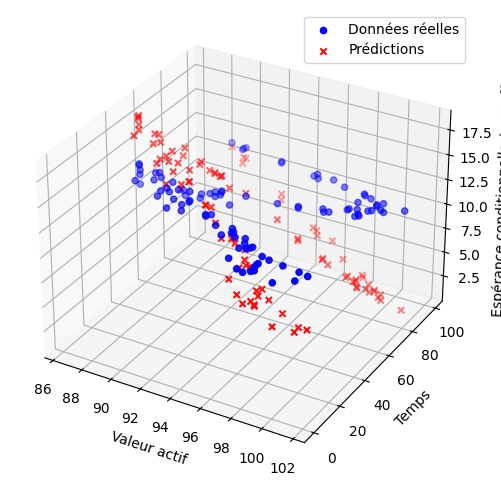

In [591]:
from mpl_toolkits.mplot3d import Axes3D

# Visualisation en 3D des données réelles et des prédictions
abscisse = [S[99][i] for i in range(100)]
temps = [i for i in range(100)]
ordonne = [phi[99][i] for i in range(100)]
pred = [predictions[i] for i in range(100)]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='3d')

# Données réelles
ax.scatter(abscisse, temps, ordonne, label='Données réelles', color='blue', marker='o')

# Prédictions
ax.scatter(abscisse, temps, pred, label='Prédictions', color='red', marker='x')

ax.set_xlabel('Valeur actif')
ax.set_ylabel('Temps')
ax.set_zlabel('Espérance conditionnelle / payoff')
ax.legend()

plt.show()

**Calcul du prix par la méthode de monté-Carlo :**

On applique la formule suivante : $P(t_0) = \frac{1}{M} \sum_{i=1}^{M} \exp\left(-r \cdot \theta \cdot (K - S(\theta))\right)$

où les temps d'arrêts $\theta$ vont être estimés avec notre modèle.

In [603]:
M = 1000
somme = 0

for _ in range(M):
    s = S0
    h = 1

    while True:
        s_scaled = scaler_S.transform(np.array([[s]]))[0, 0]
        p_scaled = scaler_p.transform(np.array([[np.max([K - s, 0])]]))[0, 0]
        t_scaled = scaler_t.transform(np.array([[h]]))[0, 0]
        predi_ = modele.predict(np.array([[s_scaled, p_scaled, h]]))
        predi = scaler_phi.inverse_transform(predi_.reshape(-1, 1)).ravel()

        # Test : est-ce un temps d'arrêt ?
        if np.max([K - s, 0]) < np.max([predi[0], 0.1]):
            s = s * np.exp(v * np.random.randn() * np.sqrt(dt) - 0.5 * np.square(v) * dt + r * dt)
            h += 1

            # Si h atteint N, sortir de la boucle
            if h == N:
                break
        else:
            break

    somme += np.max([K - s, 0])

print("Valeur du call américain:", call(K, S0, T, v, r))
print("Valeur du put américain:", somme/M)

Valeur du call américain: 6.9618416445541556
Valeur du put américain: 5.352285070654679
